## Tune density threshold to get desired DLA / HCD bias 

In [92]:
%pylab inline
# set the size of figures below
pylab.rcParams['figure.figsize'] = (10, 4)
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


/Users/James/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


We want to compute the threshold needed to get a given DLA bias. 

These notes are based on Font-Ribera & Miralda-Escudé (2012).

We will first look at a toy model to describe galaxy bias:
- The distribution of density fluctuations is described by a Gaussian $g$, with $<g>=0$ and $<g^2>=1$
- We choose a density threshold $\nu$, and those cells with $g>\nu$ will host a galaxy

In [93]:
show_plot=True
# this sets the threshold 
nu = 1.6
# probability density at the threshold
p_nu = norm.pdf(nu)
# density of galaxies is equal to the fraction of cells with density above the threshold 
mean = 1.0-norm.cdf(nu)
print('mean =',mean)

mean = 0.054799291699557995


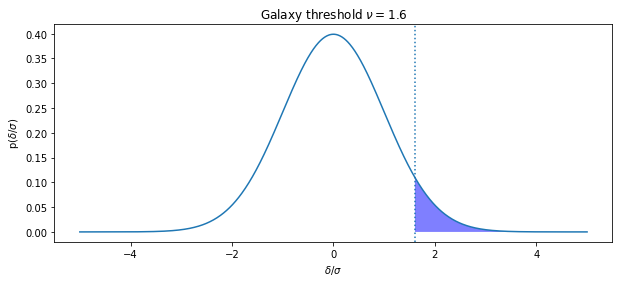

In [94]:
if show_plot:
    g = np.linspace(-5,5,1000)
    pdf = norm.pdf(g)
    plt.plot(g,pdf)
    above=(g>nu)
    plt.fill_between(g[above],0,pdf[above], facecolor='blue', alpha=0.5)
    plt.axvline(x=nu,ls=':')
    plt.xlabel('$\\delta/\\sigma$')
    plt.ylabel('p($\\delta/\\sigma$)')
    plt.title('Galaxy threshold $\\nu='+str(nu)+'$')
    plt.savefig('pdf_galaxy.pdf')

### Bias for a given threshold

We will use a slightly different notation than in Font-Ribera & Miralda-Escudé (2012). For instance, we use $\nu$ to refer to the threshold in the Normal random field $g$. Also, we want to study the bias of the peaks with respect to the correlation of $\delta = \sigma g$:

$\xi_\delta = < \delta_1 ~ \delta_2> = \sigma^2 < g_1 ~ g_2 > = \sigma^2 \rho$

We will first define the following function:

$B^2(\nu) = \frac{p(g = \nu)}{p^2(g>\nu)} \int_\nu^\infty dg ~ p(g) ~ g = \frac{p(g = \nu)}{p^2(g>\nu)} \frac{ e^{-\nu^2/2}} {\sqrt{2\pi}} = \left( \frac{p(g = \nu)}{p(g>\nu)} \right)^2$

and the correlations of the peaks will be:

$\xi_D = B^2(\nu) ~ \rho$

What we want is the correlation of the peaks to be:

$\xi_D(z) = b^2_D(z) ~ \xi(z) = b^2_D(z) ~ D^2(z) ~ \xi_0 = b^2_D(z) ~ D^2(z) ~ \sigma^2_0 ~ \rho$

So the relation is:

$B(\nu) = b_D(z) ~ D(z) ~ \sigma_0$

In [95]:
def bias_times_sigma(nu):
    # probability density at the threshold
    p_at_nu = norm.pdf(nu)
    # probability to be above the threshold
    p_above_nu = 1.0-norm.cdf(nu)
    return p_at_nu / p_above_nu

In [96]:
# explore different values of nu
nu=np.linspace(-3,3,100)
bsig_nu = bias_times_sigma(nu)

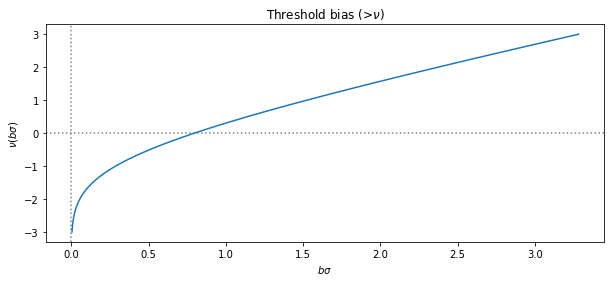

In [97]:
if show_plot:
    #plt.axvline(x=0.75,ls=':',color='gray') 
    plt.axvline(x=0,ls=':',color='gray')     
    plt.axhline(y=0,ls=':',color='gray') 
    plt.plot(bsig_nu,nu,label='galaxies')
    plt.ylabel('$\\nu(b \sigma)$')
    plt.xlabel(r'$b \sigma$')
    plt.title('Threshold bias (>$\\nu$)')
    plt.savefig('bias_threshold.pdf')

### Read $\sigma_0$ and $D(z)$ from CoLoRe to get $\nu(z)$

In [98]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [99]:
#Open data file (test file with few quasars)
hdulist = fits.open('../example_data/raw_colore_1000/out_srcs_s1_0.fits')
cosmo = hdulist[4].data
D_z = cosmo['D']
z = cosmo['Z']

In [100]:
#Get density RMS at z=0
sigma_0=hdulist[4].header['SIGMA_G']
#Get density RMS as a function of z 
sigma_z = sigma_0 * D_z
#Assume DLA bias is constant at all redshifts
dla_bias=2.0

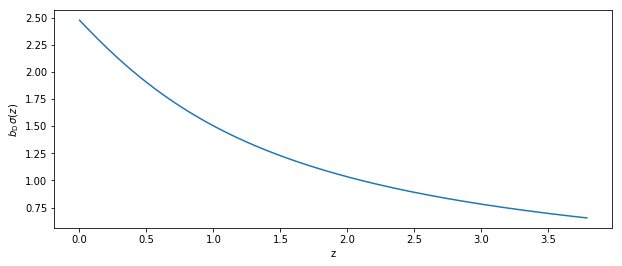

In [101]:
bsig_z=dla_bias * sigma_z
plt.plot(z,bsig_z)
#plt.xlim(2.0,3.5)
#plt.ylim(0.7,1.1)
plt.xlabel('z')
plt.ylabel(r'$b_{\rm{D}} \, \sigma(z)$')
plt.savefig('dla_bsig_z.pdf')

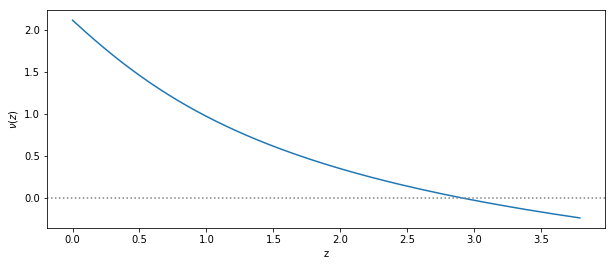

In [102]:
# compute threshold as a function of redshift
nu_z = np.interp(bsig_z,bsig_nu,nu)
plt.plot(z,nu_z)
#plt.xlim(2.0,3.5)
#plt.ylim(-0.2,0.5)
plt.xlabel('z')
plt.ylabel(r'$\nu(z)$')
#plt.axvline(x=2.3,ls=':',color='gray')     
plt.axhline(y=0,ls=':',color='gray') 
plt.savefig('dla_nu_z.pdf')

## Test that we can replicate the correct dn/dz and f(NHI)

In [103]:
#Import 
from __future__ import print_function, division
import numpy as np
import astropy.io.fits as fits
from scipy.stats import norm
from scipy.interpolate import interp1d, interp2d
import astropy.table
import os
import matplotlib.pyplot as plt

#Import pyigm modules
from pyigm.fN.fnmodel import FNModel
fN_default = FNModel.default_model()
fN_default.zmnx = (0.5,5)
fN_cosmo = fN_default.cosmo
use_pyigm = True

Using P14 spline values to generate a default model
Loading: /Users/James/anaconda3/lib/python3.6/site-packages/pyigm-0.1.dev0-py3.6.egg/pyigm/data/fN/fN_spline_z24.fits.gz


In [104]:
def dnHD_dz_cumlgN(z,logN):
    tab = astropy.table.Table.read(os.path.abspath('example_data/zheng_cumulative.overz'),format='ascii')
    y = interp2d(tab['col1'],tab['col2'],tab['col3'],fill_value=None)
    return y(z,logN)

In [105]:
def dndz(z, NHI_min=17.2, NHI_max=22.5, nsamp=1000):
    """ Get the column density distribution as a function of z,
        for a given range in N"""

    if use_pyigm:
        """
        log_NHI = np.linspace(NHI_min,NHI_max,nsamp)
        NHI = 10**log_NHI
        f = 10**(fN_default.evaluate(log_NHI, z))
        dndX = np.trapz(f,NHI,axis=0)
        dXdz = fN_cosmo.abs_distance_integrand(z)
        dndz = dndX * dXdz"""
        
        # get incidence rate per path length dX (in comoving coordinates)
        dndX = fN_default.calculate_lox(z,NHI_min,NHI_max)
        # convert dX to dz
        dXdz = fN_cosmo.abs_distance_integrand(z)
        dndz = dndX * dXdz

        return dndz

    else:
        return dnHD_dz_cumlgN(z,NHI_max)-dnHD_dz_cumlgN(z,NHI_min)

In [106]:
def get_NHI(z, NHI_min=17.2, NHI_max=22.5, nsamp=201):
    """ Get random column densities for a given z
    """
    # number of DLAs we want to generate
    Nz = len(z)
    nn_edges = np.linspace(NHI_min,NHI_max,nsamp+1)
    nn = (nn_edges[1:] + nn_edges[:-1])/2.
    nn_widths = nn_edges[1:] - nn_edges[:-1]
    
    NHI_edges = 10**nn_edges
    NHI_widths = NHI_edges[1:] - NHI_edges[:-1]    
    
    probs = np.zeros([Nz,nsamp])

    if use_pyigm:
        auxfN = fN_default.evaluate(nn,z)
        
        #original probs
        # Above we got logprob in a grid NHI,z (note the order, we will transpose)
        #probs = (10**(auxfN)/np.sum(10**(auxfN), axis=0)).T # The probability is the function divided by the sum for a given z
        
        #new attempt
        f = 10**(auxfN)
        n_bar = f*np.outer(NHI_widths,np.ones(z.shape))
        probs = (n_bar/np.sum(n_bar,axis=0)).T
        
    else:
        probs_low = dnHD_dz_cumlgN(z,nn[:-1]).T
        probs_high = dnHD_dz_cumlgN(z,nn[1:]).T
        probs[:,1:] = probs_high-probs_low
        
    cumulative = np.zeros(probs.shape)
    for i in range(nsamp):
        cumulative[:,i] = np.sum(probs[:,:i],axis=1)
    
    nn_interp = np.concatenate([[nn_edges[0]],nn,[nn_edges[1]]])
    end_0 = np.zeros((z.shape[0],1))
    end_1 = np.ones((z.shape[0],1))
    cumulative_interp = np.concatenate([end_0,cumulative,end_1],axis=1)
    
    NHI = np.zeros(Nz)
    for i in range(Nz):
        #original
        #NHI[i] = np.random.choice(nn,size=1,p=probs[i]/np.sum(probs[i]))+(nn[1]-nn[0])*np.random.random(size=1)
        
        p = np.random.uniform()
        NHI[i] = np.interp(p,cumulative_interp[i,:],nn_interp)
        
    return NHI

In [107]:
#Define the parameters of the DLAs we wish to produce:
NHI_min = 17.2
NHI_max = 22.5
seed = 123
N_qso = 100000
z_qso = np.random.uniform(size=N_qso)*2. + 1.8

#Define a redshift skewer, its edges and its widths:
#z_cell = np.linspace(1.5,4.1,501)
z_cell = cosmo['Z'][cosmo['Z']>1.5]
zedges = np.concatenate([[z_cell[0]]-(z_cell[1]-z_cell[0])/2.,(z_cell[1:]+z_cell[:-1])*0.5,[z_cell[-1]+(-z_cell[-2]+z_cell[-1])*0.5]]).ravel()
z_width = zedges[1:]-zedges[:-1]

#Define some NHI bins
N_intervals = [(17.2,22.0),(17.2,20.3),(20.3,22.0)]

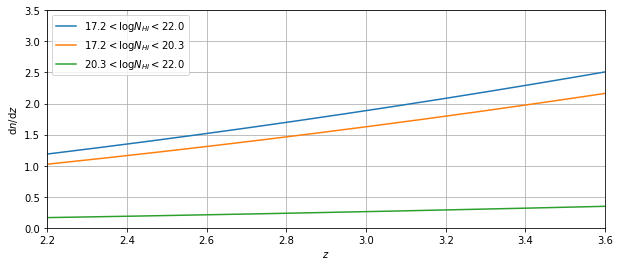

In [108]:
#Test the dndz function to replicate Font-Ribera et al. 2012 Figure 1, right panel
for k,N_int in enumerate(N_intervals):
    NHI_min = N_int[0]
    NHI_max = N_int[1]
    dndz_values = dndz(z_cell,NHI_min=NHI_min,NHI_max=NHI_max)
    plt.plot(z_cell,dndz_values,label=r'${}<\log N_{{HI}}<{}$'.format(NHI_min,NHI_max),c='C{}'.format(k))
    
plt.xlim(2.2,3.6)
plt.ylim(0.0,3.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{{d}}n / \mathrm{{d}}z$')
plt.legend()
plt.grid()
plt.show()

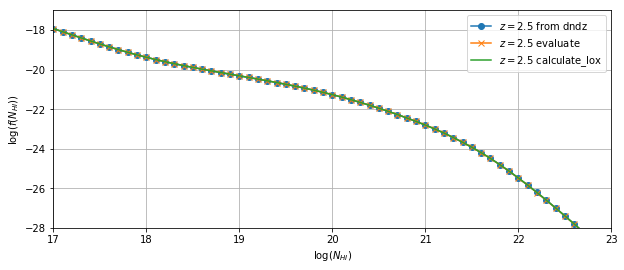

In [109]:
#Now check that we understand the functions to give f(NHI)
z_values = [2.5]#[2.2,2.6,3.0,3.4]

log_NHI = np.linspace(17.0,23.0,61)
log_NHI_edges = np.concatenate([[log_NHI[0]]-(log_NHI[1]-log_NHI[0])/2.,(log_NHI[1:]+log_NHI[:-1])*0.5,[log_NHI[-1]+(-log_NHI[-2]+log_NHI[-1])*0.5]]).ravel()
log_NHI_width = log_NHI_edges[1:]-log_NHI_edges[:-1]

NHI = 10**(log_NHI)
NHI_edges = 10**(log_NHI_edges)
NHI_width = NHI_edges[1:]-NHI_edges[:-1]

for z_value in z_values:
    
    #From dndz
    dndz_values = []
    for i in range(log_NHI_edges.shape[0]-1):
        dndz_values += [dndz(z_value,NHI_min=log_NHI_edges[i],NHI_max=log_NHI_edges[i+1])]
    dndz_values = np.array(dndz_values).reshape(log_NHI.shape[0])
    dXdz = fN_cosmo.abs_distance_integrand(z_value)
    f_dndz = dndz_values/(dXdz*NHI_width)
    plt.plot(log_NHI,np.log10(f_dndz),label=r'$z={}$ from dndz'.format(z_value),marker='o')

    #From evaluate function
    f_eval = 10**(fN_default.evaluate(log_NHI, z_value).reshape(log_NHI.shape[0]))
    plt.plot(log_NHI,np.log10(f_eval),label=r'$z={}$ evaluate'.format(z_value),marker='x')

    #From calculate_lox function
    f_lox = np.zeros(log_NHI.shape)
    for i in range(log_NHI_edges.shape[0]-1):
        f_lox[i] = 10**(np.log10(fN_default.calculate_lox(z_value,log_NHI_edges[i],log_NHI_edges[i+1])/(np.log(10)*log_NHI_width[i])) - log_NHI[i])
    plt.plot(log_NHI,np.log10(f_lox),linestyle='-',label=r'$z={}$ calculate_lox'.format(z_value))
    
plt.xlim(17.0,23.0)
plt.ylim(-28.0,-17.0)
plt.ylabel(r'$\log(f(N_{{HI}}))$')
plt.xlabel(r'$\log(N_{{HI}})$')
plt.legend()
plt.grid()
plt.show()

In [110]:
#Function to measure dn/dz from dlas in cell
def measure_dndz_cell(dlas_in_cell,z_bins,z_cell):
    N_qso = dlas_in_cell.shape[0]
    z_edges = np.concatenate([[z_cell[0]-(z_cell[1]-z_cell[0])/2.],(z_cell[1:]+z_cell[:-1])/2.,[z_cell[-1]+(z_cell[-1]-z_cell[2])/2.]])
    n = np.zeros(len(z_bins))
    z = np.zeros(len(z_bins))
    z_widths = np.zeros(len(z_bins))
    for k,z_bin in enumerate(z_bins):
        z_min = z_bin[0]
        z_max = z_bin[1]
        cells = (z_cell<=z_max)*(z_cell>z_min)
        dz = z_edges[1:][cells][-1] - z_edges[:-1][cells][0]
        n[k] = np.sum(dlas_in_cell[:,cells])
        z[k] = np.average(z_cell[cells])
        z_widths[k] = dz
    dndz = n/(z_widths*N_qso)
    return z,dndz

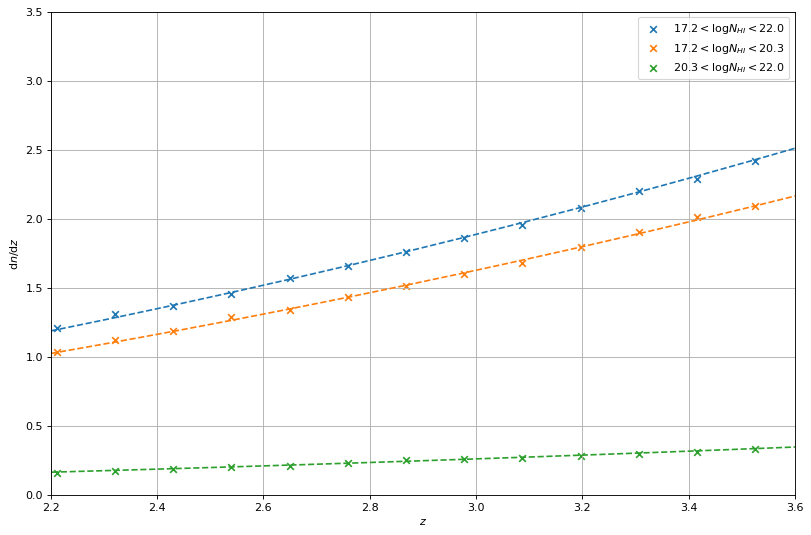

In [111]:
#Measure dndz and check that it matches the input.
z_edges = np.linspace(1.5,3.8,22)
z_bins = []
for i in range(z_edges.shape[0]-1):
    z_bins += [(z_edges[i],z_edges[i+1])]

plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

N_intervals = [(17.2,22.0),(17.2,20.3),(20.3,22.0)]
for k,N_int in enumerate(N_intervals):
    NHI_min_bin = N_int[0]
    NHI_max_bin = N_int[1]
    
    N_qso_bin = 100000
    mean_N_per_cell_bin = z_width*dndz(z_cell,NHI_min_bin,NHI_max_bin)
    mu_Nbin = mean_N_per_cell_bin
    pois_Nbin = np.random.poisson(mu_Nbin,size=(N_qso_bin,len(mu_Nbin)))
    dlas_in_cell_Nbin = pois_Nbin

    z_values,dndz_measured = measure_dndz_cell(dlas_in_cell_Nbin,z_bins,z_cell)
    plt.scatter(z_values,dndz_measured,marker='x',label=r'${}<\log N_{{HI}}<{}$'.format(NHI_min_bin,NHI_max_bin))

    dndz_model = dndz(z_values,NHI_min_bin,NHI_max_bin)
    plt.plot(z_values,dndz_model,c='C{}'.format(k),linestyle='--')

plt.xlim(2.2,3.6)
plt.ylim(0.0,3.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{{d}}n / \mathrm{{d}}z$')
plt.legend()
plt.grid()
plt.savefig('dndz_in_cell.pdf')
plt.show()

In [112]:
#Place DLAs according to the input n(z).
NHI_min = 17.2
NHI_max = 23.0
#Now assign DLAs in the skewers randomly.
#Get the average number of DLAs per cell, from the column density dist.
mean_N_per_cell = z_width*dndz(z_cell,NHI_min,NHI_max)

"""
#Don't need this for now as we don't have cell flagging.
#For a given z, probability of having the density higher than the threshold
p_nu_z = 1.0-norm.cdf(nu_arr)

#Define mean of the Poisson distribution (per cell)
mu = mean_N_per_cell/p_nu_z
"""
mu = mean_N_per_cell

#Select cells that will hold a DLA, drawing from the Poisson distribution
pois = np.random.poisson(mu,size=(N_qso,len(mu)))

"""
#Again, don't need this for now as we're not doing any flagging
dlas_in_cell = pois*flagged_cells
"""
dlas_in_cell = pois

#Remove DLAs beyond the QSOs
for i in range(N_qso):
    dlas_in_cell[i,:] *= (z_cell<z_qso[i])

In [113]:
#Now assign NHI values to all of the DLAs.
ndlas = np.sum(dlas_in_cell)

#Store information for each of the DLAs that will be added
dla_z = np.zeros(ndlas)
dla_count = 0

for skw_id,dla in enumerate(dlas_in_cell):
    dla_cells = np.where(dla>0)[0]
    for cell in dla_cells:
        #dla_z[dla_count:dla_count+dla[cell]] = np.ones(dla[cell])*(zedges[cell]+zedges[cell+1])/2.
        dla_z[dla_count:dla_count+dla[cell]] = np.random.uniform(low=(zedges[cell]),high=(zedges[cell+1]),size=dla[cell])
        dla_count = dla_count+dla[cell]

dla_NHI = get_NHI(dla_z,NHI_min=NHI_min,NHI_max=NHI_max)

In [114]:
#Function to measure dn/dz from list of dla redshifts and NHIs

def measure_dndz(dla_z,dla_NHI,log_NHI_bin,z_bins):

    #Filter the DLAs according to the bin in log NHI.
    log_NHI_min = log_NHI_bin[0]
    log_NHI_max = log_NHI_bin[1]
    relevant_dlas = (dla_NHI>log_NHI_min) * (dla_NHI<log_NHI_max)
    dla_z = dla_z[relevant_dlas]

    n = np.zeros(len(z_bins))
    z = np.zeros(len(z_bins))
    z_widths = np.zeros(len(z_bins))

    for k,z_bin in enumerate(z_bins):
        z_min = z_bin[0]
        z_max = z_bin[1]

        #Use the QSO data to determine the effective redshift interval over all QSOs.
        z_low = np.ones(z_qso.shape)*z_min
        z_high = np.minimum(np.maximum(z_qso,z_min),z_max)
        z_intervals = z_high-z_low
        dz_total = np.sum(z_intervals)
        z_widths[k] = dz_total

        #Use the QSO data to get the average redshift of the bin.
        z_samp_edges = np.linspace(z_min,z_max,101)
        z_samp = (z_samp_edges[1:] + z_samp_edges[:-1])/2.
        N_samp = np.zeros(z_samp.shape)
        for i,z_s in enumerate(z_samp):
            N_samp[i] = np.sum(z_high>z_samp_edges[i+1])
        z[k] = np.average(z_samp,weights=N_samp)

        #Count the DLAs in the bin.
        dlas_in_z_bin = (dla_z<=z_max)*(dla_z>z_min)
        n[k] = np.sum(dlas_in_z_bin)

    #Calculate dndz
    dndz = n/(z_widths)

    return z,dndz

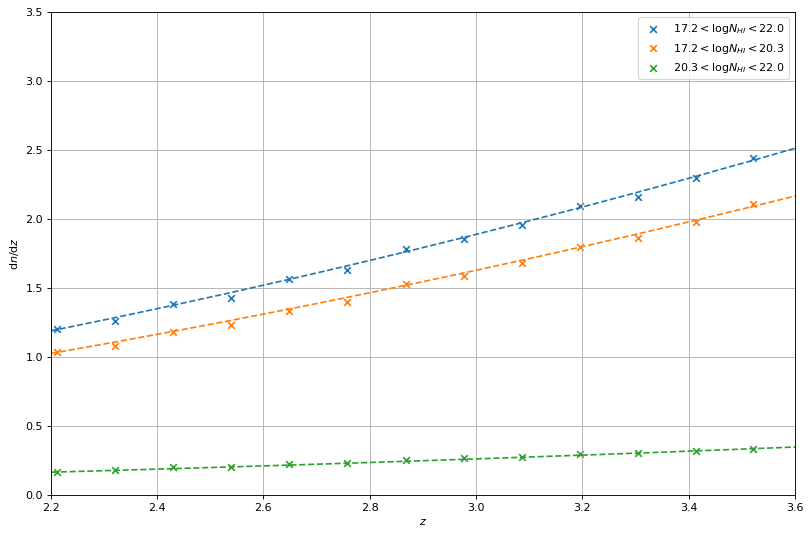

In [115]:
#Measure dndz and check that it matches the input.
z_edges = np.linspace(1.5,3.8,22)
z_bins = []
for i in range(z_edges.shape[0]-1):
    z_bins += [(z_edges[i],z_edges[i+1])]

plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

N_intervals = [(17.2,22.0),(17.2,20.3),(20.3,22.0)]

for k,N_int in enumerate(N_intervals):
    
    NHI_min_bin = N_int[0]
    NHI_max_bin = N_int[1]

    z_values,dndz_measured = measure_dndz(dla_z,dla_NHI,N_int,z_bins)
    plt.scatter(z_values,dndz_measured,marker='x',label=r'${}<\log N_{{HI}}<{}$'.format(NHI_min_bin,NHI_max_bin))
    
    dndz_model = dndz(z_values,NHI_min_bin,NHI_max_bin)
    plt.plot(z_values,dndz_model,c='C{}'.format(k),linestyle='--')

plt.xlim(2.2,3.6)
plt.ylim(0.0,3.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{{d}}n / \mathrm{{d}}z$')
plt.legend()
plt.grid()
plt.savefig('dndz.pdf')
plt.show()

In [116]:
#Function to measure f(NHI) from list of dla redshifts and NHIs
def measure_fNHI(dla_z,dla_NHI,z_bin,log_NHI_bin_edges,z_cell,z_qso):
    
    #Make the NHI bins.
    log_NHI_bins = []
    for i in range(log_NHI_bin_edges.shape[0]-1):
        log_NHI_bins += [(log_NHI_bin_edges[i],log_NHI_bin_edges[i+1])]
    log_NHI_bins = np.array(log_NHI_bins)
    NHI_bin_edges = 10**(log_NHI_bin_edges)
    NHI_bin_widths = NHI_bin_edges[1:] - NHI_bin_edges[:-1]

    #Filter the DLAs by z bin
    z_min = z_bin[0]
    z_max = z_bin[1]
    dlas_in_z_bin = (dla_z<=z_max)*(dla_z>=z_min)

    #Use the QSO data to determine the effective redshift interval over all QSOs.
    z_low = np.ones(z_qso.shape)*z_min
    z_high = np.minimum(np.maximum(z_qso,z_min),z_max)
    dz_total = np.sum(z_high-z_low)

    #Use the QSO data to get the average redshift of the bin.
    z_samp_edges = np.linspace(z_min,z_max,101)
    z_samp = (z_samp_edges[1:] + z_samp_edges[:-1])/2.
    N_samp = np.zeros(z_samp.shape)
    for i,z_s in enumerate(z_samp):
        N_samp[i] = np.sum(z_high>z_samp_edges[i+1])
    z_val = np.average(z_samp,weights=N_samp)

    #Calculate dX_total
    dX_total = fN_cosmo.abs_distance_integrand(z_val) * dz_total

    #In each of the NHI bins, count the DLAs
    n_values = []
    log_NHI_values = []
    
    for i,lNb in enumerate(log_NHI_bins):
        log_NHI_min = lNb[0]
        log_NHI_max = lNb[1]
        counters = (dla_NHI[dlas_in_z_bin]>log_NHI_min)*(dla_NHI[dlas_in_z_bin]<log_NHI_max)
        n_value = np.sum(counters)
        n_values += [n_value]
        if n_value>0:
            log_NHI_eff = np.log10(np.average(10**dla_NHI[dlas_in_z_bin][counters]))
        else:
            log_NHI_eff = (log_NHI_max+log_NHI_min)/2.
        log_NHI_values += [log_NHI_eff]
  
    n_values = np.array(n_values)
    log_NHI_values = np.array(log_NHI_values)
    
    #Calculate f by dividing by the bin width and the effective absorption length (dX in each of N_qso skewers)
    f_values = n_values/(NHI_bin_widths*dX_total)
    
    return z_val,log_NHI_values,f_values

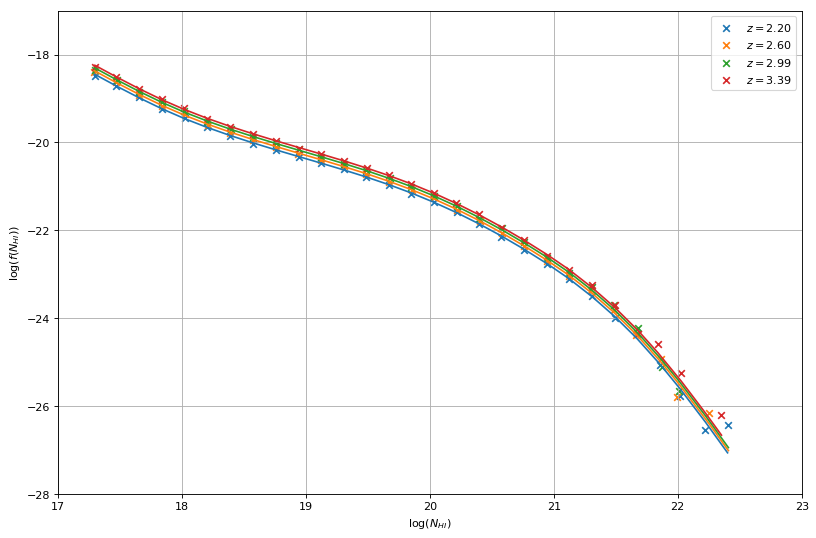

In [117]:
#Measure f(NHI)
z_bins = [(2.1,2.3),(2.5,2.7),(2.9,3.1),(3.3,3.5)]
log_NHI_bin_edges = np.linspace(17.2,22.5,30)

plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

for k,z_bin in enumerate(z_bins):

    #Measure the f values and scatter plot.
    z_val,log_NHI_values,f_values = measure_fNHI(dla_z,dla_NHI,z_bin,log_NHI_bin_edges,z_cell,z_qso)
    non_empty = (f_values > 0)
    plt.scatter(log_NHI_values[non_empty],np.log10(f_values[non_empty]),label=r'$z={:1.2f}$'.format(z_val),c='C{}'.format(k),marker='x')
    
    #Compute the input from pyigm and plot a line,.
    log10_f_model = fN_default.evaluate(log_NHI_values,z_val).reshape(log_NHI_values.shape[0])
    plt.plot(log_NHI_values,log10_f_model,c='C{}'.format(k))
    
    #plt.plot(log_NHI_values,(f_values-10**log10_f_model)/(10**log10_f_model),label=r'$z={:1.2f}$'.format(z_val),c='C{}'.format(k))

#Control the axes etc of the plot.
plt.xlim(17.0,23.0)
plt.ylim(-28.0,-17.0)
#plt.xlim(18.5,20.0)
#plt.ylim(-21.0,-20.0)
#plt.ylim(-0.1,0.1)
plt.ylabel(r'$\log(f(N_{{HI}}))$')
plt.xlabel(r'$\log(N_{{HI}})$')
plt.legend()
plt.grid()
#plt.savefig('f_NHI.pdf')
plt.show()

# Combine everything with some fake skewers

In [311]:
h = fits.open('/Users/James/Downloads/master.fits')
z_cat = h['CATALOG'].data['Z_QSO_NO_RSD']
z_cosmo = h['COSMO_COL'].data['Z']
D_cosmo = h['COSMO_COL'].data['D']

#Find a selection of quasars to reduce the data to a specific number
N_qso = 100000
z_qso = np.random.choice(z_cat,size=N_qso,replace=False)

"""
#Filter the QSOs by pixel on the sky
pixel = 0
qsos = h['CATALOG'].data['PIXNUM'] == pixel
z_qso = z_cat[qsos]
N_qso = z_qso.shape[0]"""

"\n#Filter the QSOs by pixel on the sky\npixel = 0\nqsos = h['CATALOG'].data['PIXNUM'] == pixel\nz_qso = z_cat[qsos]\nN_qso = z_qso.shape[0]"

In [312]:
"""
#Generate a large qso catalog with roughly the right redshift distribution
z_qso_initial = hdulist['CATALOG'].data['Z_COSMO']
N_extend = 150
z_qso_new = z_qso_initial
for i in range(N_extend-1):
    z_qso_new = np.concatenate((z_qso_new,(z_qso_initial+(np.random.uniform(size=z_qso_initial.shape)-0.5)*0.2)))
z_qso_new = z_qso_new[(z_qso_new>1.8)*(z_qso_new<3.8)]
z_qso = z_qso_new
N_qso = z_qso_new.shape[0]
"""

"\n#Generate a large qso catalog with roughly the right redshift distribution\nz_qso_initial = hdulist['CATALOG'].data['Z_COSMO']\nN_extend = 150\nz_qso_new = z_qso_initial\nfor i in range(N_extend-1):\n    z_qso_new = np.concatenate((z_qso_new,(z_qso_initial+(np.random.uniform(size=z_qso_initial.shape)-0.5)*0.2)))\nz_qso_new = z_qso_new[(z_qso_new>1.8)*(z_qso_new<3.8)]\nz_qso = z_qso_new\nN_qso = z_qso_new.shape[0]\n"

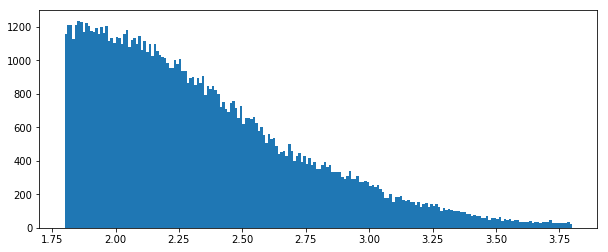

In [313]:
plt.hist(z_qso,bins=200)
plt.show()

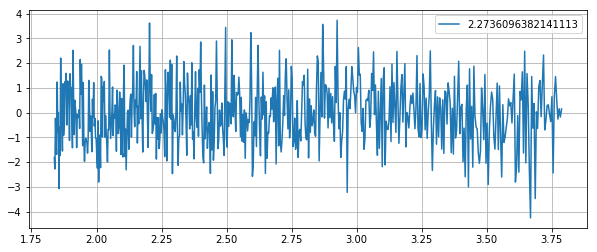

In [354]:
#Make fake Gaussian skewers with roughly the right sigma
#Define the parameters of the DLAs we wish to produce:
NHI_min = 17.2
NHI_max = 22.5
seed = 123

#Define a redshift skewer, its edges and its widths:
#z_cell = np.linspace(1.5,4.1,501)
z_min = 1.837 #Mimic make_transmission settings
z_cell = z_cosmo[z_cosmo>z_min]
zedges = np.concatenate([[z_cell[0]]-(z_cell[1]-z_cell[0])/2.,(z_cell[1:]+z_cell[:-1])*0.5,[z_cell[-1]+(-z_cell[-2]+z_cell[-1])*0.5]]).ravel()
z_width = zedges[1:]-zedges[:-1]

dla_bias = 2.0
dla_bias_z = 2.25
method = 'b_const'
sigma_g = 1.1670964907388162
deltas = np.random.normal(size=(N_qso,z_cell.shape[0]),scale=sigma_g)
D_cell = D_cosmo[z_cosmo>z_min]

i=1
plt.plot(z_cell,deltas[i,:],label=str(z_qso[i]))
plt.legend()
plt.grid()
plt.show()

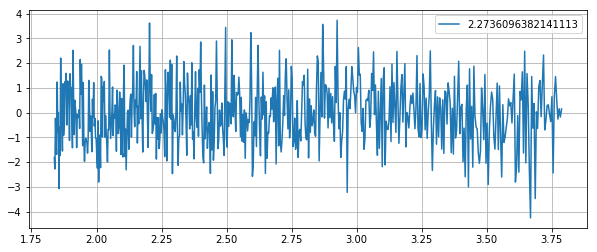

In [355]:
#Scale the gaussian field near the QSOs
def shift_up(z_qso,z_cell,mult=5.,width=0.04):
    addition = np.zeros((z_qso.shape[0],z_cell.shape[0]))
    for i,zq in enumerate(z_qso):
        z_sel = z_cell<z_qso[i]
        zs = z_cell[z_sel]
        addition[i,z_sel] = mult*np.exp((zs-z_qso[i])/width)
    return addition

addition = shift_up(z_qso,z_cell,mult=1.0,width=0.05)
deltas += addition
plt.plot(z_cell,deltas[i,:],label=str(z_qso[i]))
plt.legend()
plt.grid()
plt.show()

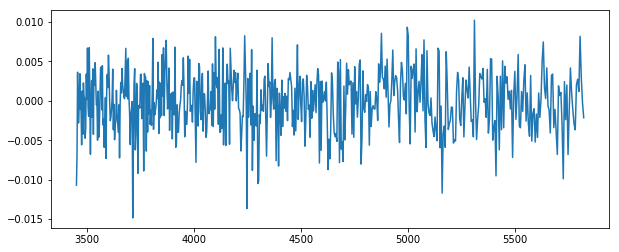

In [356]:
plt.plot(1215.67*(1+z_cell),np.average(deltas,axis=0))
plt.show()

In [357]:
#Functions to determine the threshold in the Gaussian field and flag cells in delta skewers.
def nu_of_bDs(bDs):
    """ Compute the Gaussian field threshold for a given bias"""
    nu = np.linspace(-10,100,500) # Generous range to interpolate
    p_nu = norm.pdf(nu)
    galaxy_mean = 1.0-norm.cdf(nu)
    bDs_nu = np.zeros(nu.shape)
    bDs_nu[galaxy_mean!=0] = p_nu[galaxy_mean!=0]/galaxy_mean[galaxy_mean!=0]
    y = interp1d(bDs_nu,nu)
    return y(bDs)

def flag_DLA(zq,z_cells,deltas,nu_arr,sigma_g):
    """ Flag the pixels in a skewer where DLAs are possible"""
    # find cells with density above threshold
    # TODO: why do we multiply nu by sigma_g here?
    flag = deltas > nu_arr*sigma_g
    # mask cells with z > z_qso, where DLAs would not be observed
    Nq=len(zq)
    for i in range(Nq):
        low_z = z_cells < zq[i]
        flag[i,:] *= low_z
    return flag

In [358]:
#Compute the threshold and flag cells.
y = interp1d(z_cell,D_cell)
if method == "b_const":
    b_D_sigma0 = dla_bias*D_cell*sigma_g
elif method == "bD_const":
    b_D_sigma0 = dla_bias*y(dla_bias_z)*sigma_g*np.ones(z_cell.shape)
else:
    raise ValueError('DLA bias method not recognised.')
nu_arr = nu_of_bDs(b_D_sigma0)
flagged_cells = flag_DLA(z_qso,z_cell,deltas,nu_arr,sigma_g)

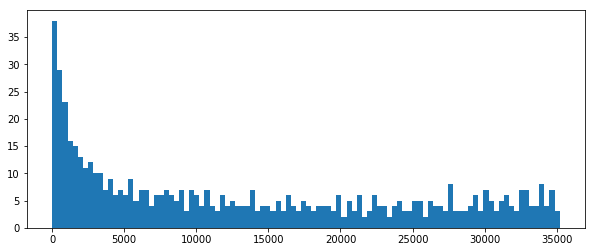

In [359]:
plt.hist(np.sum(flagged_cells,axis=0),bins=100)
plt.show()

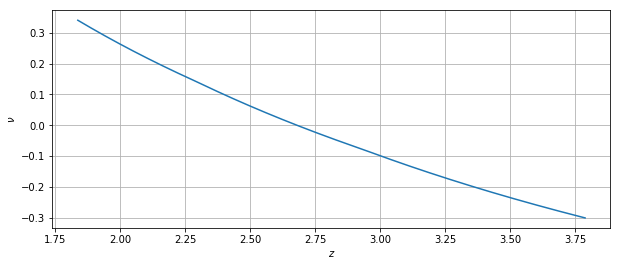

In [360]:
plt.plot(z_cell,nu_arr)
plt.grid()
plt.ylabel(r'$\nu$')
plt.xlabel(r'$z$')
plt.show()

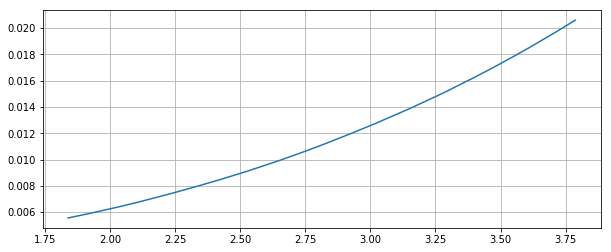

In [361]:
#Get the average number of DLAs per cell, from the column density dist.
mean_N_per_cell = z_width * dndz(z_cell,NHI_min=NHI_min,NHI_max=NHI_max)

#print(z_cell)
#print(z_width)
#print(NHI_min,NHI_max)
#print(mean_N_per_cell)
#print(mu)
#For a given z, probability of having the density higher than the threshold
p_nu_z = 1.0-norm.cdf(nu_arr)

#Define mean of the Poisson distribution (per cell)
mu = mean_N_per_cell/p_nu_z

plt.plot(z_cell,mu)
plt.grid()
plt.show()


In [362]:
#Select cells that will hold a DLA, drawing from the Poisson distribution
pois = np.random.poisson(mu,size=(len(z_qso),len(mu)))
#Number of DLAs in each cell (mostly 0, several 1, not many with >1)
dlas_in_cell = pois*flagged_cells

In [363]:
print(np.sum(dlas_in_cell))

62222


In [364]:
#Now assign NHI values to all of the DLAs.
ndlas = np.sum(dlas_in_cell)

#Store information for each of the DLAs that will be added
dla_z = np.zeros(ndlas)
dla_count = 0

for skw_id,dla in enumerate(dlas_in_cell):
    dla_cells = np.where(dla>0)[0]
    for cell in dla_cells:
        #dla_z[dla_count:dla_count+dla[cell]] = np.ones(dla[cell])*(zedges[cell]+zedges[cell+1])/2.
        dla_z[dla_count:dla_count+dla[cell]] = np.random.uniform(low=(zedges[cell]),high=(zedges[cell+1]),size=dla[cell])
        dla_count = dla_count+dla[cell]

dla_NHI = get_NHI(dla_z,NHI_min=NHI_min,NHI_max=NHI_max)

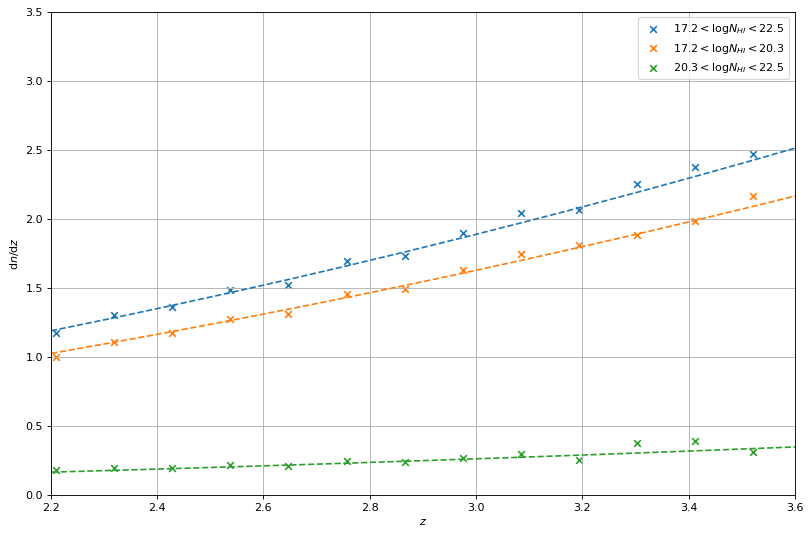

In [365]:
#Measure dndz and check that it matches the input.
z_edges = np.linspace(1.5,3.8,22)
z_bins = []
for i in range(z_edges.shape[0]-1):
    z_bins += [(z_edges[i],z_edges[i+1])]

plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

N_intervals = [(17.2,22.5),(17.2,20.3),(20.3,22.5)]

for k,N_int in enumerate(N_intervals):
    
    NHI_min_bin = N_int[0]
    NHI_max_bin = N_int[1]

    z_values,dndz_measured = measure_dndz(dla_z,dla_NHI,N_int,z_bins)
    plt.scatter(z_values,dndz_measured,marker='x',label=r'${}<\log N_{{HI}}<{}$'.format(NHI_min_bin,NHI_max_bin))
    
    dndz_model = dndz(z_values,NHI_min_bin,NHI_max_bin)
    plt.plot(z_values,dndz_model,c='C{}'.format(k),linestyle='--')

plt.xlim(2.2,3.6)
plt.ylim(0.0,3.5)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{{d}}n / \mathrm{{d}}z$')
plt.legend()
plt.grid()
plt.savefig('dndz_random_skewers.pdf')
plt.show()

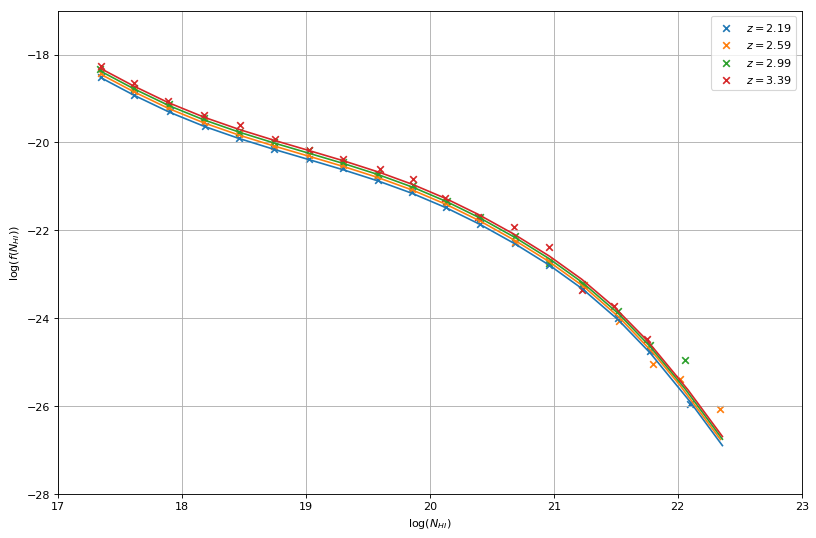

In [310]:
#Measure f(NHI)
z_bins = [(2.1,2.3),(2.5,2.7),(2.9,3.1),(3.3,3.5)]
log_NHI_bin_edges = np.linspace(17.2,22.5,20)

plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

for k,z_bin in enumerate(z_bins):

    #Measure the f values and scatter plot.
    z_val,log_NHI_values,f_values = measure_fNHI(dla_z,dla_NHI,z_bin,log_NHI_bin_edges,z_cell,z_qso)
    non_empty = (f_values > 0)
    plt.scatter(log_NHI_values[non_empty],np.log10(f_values[non_empty]),label=r'$z={:1.2f}$'.format(z_val),c='C{}'.format(k),marker='x')
    
    #Compute the input from pyigm and plot a line,.
    log10_f_model = fN_default.evaluate(log_NHI_values,z_val).reshape(log_NHI_values.shape[0])
    plt.plot(log_NHI_values,log10_f_model,c='C{}'.format(k))
    
    #plt.plot(log_NHI_values,(f_values-10**log10_f_model)/(10**log10_f_model),label=r'$z={:1.2f}$'.format(z_val),c='C{}'.format(k))

#Control the axes etc of the plot.
plt.xlim(17.0,23.0)
plt.ylim(-28.0,-17.0)
#plt.xlim(18.5,20.0)
#plt.ylim(-21.0,-20.0)
#plt.ylim(-0.1,0.1)
plt.ylabel(r'$\log(f(N_{{HI}}))$')
plt.xlabel(r'$\log(N_{{HI}})$')
plt.legend()
plt.grid()
#plt.savefig('f_NHI.pdf')
plt.show()

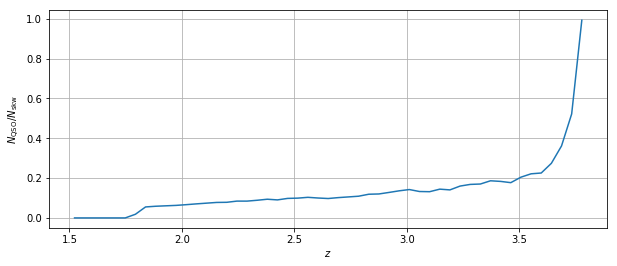

In [373]:
z_edges = np.linspace(1.5,3.8,52)
z_bins = []
z_values = []
for i in range(z_edges.shape[0]-1):
    z_bins += [(z_edges[i],z_edges[i+1])]
    z_values += [(z_edges[i]+z_edges[i+1])/2.]
    
N_qso_per_bin = np.zeros(len(z_bins))
N_skewers_per_bin = np.zeros(len(z_bins))
for i,z_bin in enumerate(z_bins):
    N_skewers_per_bin[i] = np.sum(z_qso>z_bin[0])
    N_qso_per_bin[i] = np.sum((z_qso>z_bin[0])*(z_qso<z_bin[1]))

plt.plot(z_values,(N_qso_per_bin/N_skewers_per_bin))
plt.grid()
plt.xlabel(r'$z$')
plt.ylabel(r'$N_{\rm{QSO}} / N_{\rm{skw}}$')
plt.savefig('QSO_to_skw_ratio.pdf')
plt.show()

In [27]:
#For every cell in a grid, assign an NHI value
grid_NHI = np.zeros((Nq,z_cell.shape[0]))
for i in range(Nq):
    grid_NHI[i,:] = get_N(z_cell, z_width, NHI_min=17.0, NHI_max=22.5, nsamp=100)

TypeError: get_N() got multiple values for argument 'Nmin'

In [ ]:
#In z bins, NHI bins
z_bins = [(2.1,2.3)]#[(2.1,2.3),(2.5,2.7),(2.9,3.1),(3.3,3.5)]
log_NHI_bin_edges = np.linspace(17.0,22.5,10)
log_NHI_bins = []
for i in range(log_NHI_bin_edges.shape[0]-1):
    log_NHI_bins += [(log_NHI_bin_edges[i],log_NHI_bin_edges[i+1])]
log_NHI_bins = np.array(log_NHI_bins)

NHI_bin_edges = 10**(log_NHI_bin_edges)
NHI_bin_widths = NHI_bin_edges[1:] - NHI_bin_edges[:-1]

for k,z_bin in enumerate(z_bins):
    
    z_min = z_bin[0]
    z_max = z_bin[1]
    
    cells = (z_cell<=z_max)*(z_cell>=z_min)
    dz = z_max - z_min
    dX = np.sum(fN_cosmo.abs_distance_integrand(z_cell[cells]) * z_width[cells])
    
    z_val = np.average(z_cell[cells])
    
    n_values = []
    log_NHI_values = []
    f_values = []
    
    for i,lNb in enumerate(log_NHI_bins):
        log_NHI_min = lNb[0]
        log_NHI_max = lNb[1]
        counters = (grid_NHI[:,cells]>log_NHI_min)*(grid_NHI[:,cells]<log_NHI_max)
        n_value = np.sum(counters)
        n_values += [n_value]
        if n_value>0:
            log_NHI_eff = np.average(grid_NHI[:,cells][counters])
        else:
            log_NHI_eff = (log_NHI_max+log_NHI_min)/2.
        log_NHI_values += [log_NHI_eff]
        
        #f_values += [n_value/(Nq*NHI_bin_widths[i]*dX)]
        
    log_NHI_values = np.array(log_NHI_values)
    n_values = np.array(n_values)
    
    p_values = n_values/np.sum(n_values)          
    f_values = p_values/NHI_bin_widths
    
    #f_values = n_values/(np.sum(n_values)*NHI_bin_widths)
    #f_values = np.array(f_values)
    

    nonemp = n_values>0
    
    plt.scatter(log_NHI_values[nonemp],np.log10(f_values[nonemp]),label=r'$z={:1.2f}$'.format(z_val),c='C{}'.format(k),marker='x')
    
    log10_f_model = fN_default.evaluate(log_NHI_values,z_val).reshape(log_NHI_values.shape[0])
    plt.plot(log_NHI_values,log10_f_model,c='C{}'.format(k))

    #plt.plot(log_NHI_values,np.log10(np.array(f_values))-log10_f_model,label=r'$z={:1.2f}$'.format(z_val),c='C{}'.format(k))

    

plt.xlim(17.0,23.0)
#plt.ylim(-28.0,-17.0)
#plt.ylabel(r'$\log(f(N_{{HI}}))$')
plt.xlabel(r'$\log(N_{{HI}})$')
plt.legend()
plt.grid()
plt.show()